## Basic Co-Occurrence Analysis of Human-Cell-Atlas Pancreas Topograhic Maps

Data from Tosti et al, 2021

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt

In [3]:
from sonar import sonar, utils

In [4]:
rel_kernel_path = 'test/ISS-pancreas' #"."


In [5]:
# Load the coordinates for osmFISH mouse cortex:

import csv

genes,x,y = [],[],[]

header = None
with open (os.path.join( *rel_kernel_path.split('/'), 'data','coordinates.csv')) as file:
    reader = csv.reader(file)
    for row in reader:
        if header is None:
            header = row
        else:
            genes.append(row[0])
            x.append(float(row[1]))
            y.append(float(row[2]))

x = np.array(x).astype(float)
y = np.array(y).astype(float)


gene_categories = list(set(genes))
gene_dict = {gene_categories[i]:i for i in range(len(gene_categories))}
genes = np.array([gene_dict[gene] for gene in genes])


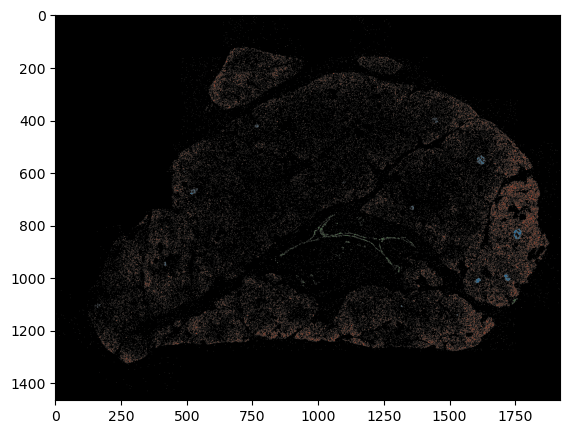

In [6]:
from sonar.utils import PointProcess

count_ids = np.unique(genes, return_counts=True)[1].argsort()

point_process = PointProcess(x,y,genes,rescale_factor=0.08,device='cpu')

plt.figure(figsize=(10,5))


tissues = ['PRSS2','MUC5B','INS',]
cmaps = ['Reds','Greens','Blues']

for i in range(len(tissues)):

    hist = point_process[gene_categories.index(tissues[i])].cpu().numpy()
    plt.imshow(hist**0.1,cmap=cmaps[i],alpha=(hist>0).astype(float))
    
plt.gca().set_facecolor('black')

Changing tasks between cpu and gpu

In [7]:
import torch

if torch.cuda.is_available():
    import torch as t
    device = 'cuda:0' # put it in a gpu
else:
    import torch as t
    device='cpu'


# unrelated to the NoteBook, the example of a tensor and how to work with it
new_tens = t.zeros(2,2,2, device=device).cuda()
new_tens.device

device(type='cuda', index=0)

In [15]:
point_process = PointProcess(x,y,genes,rescale_factor=0.03,device=device)


rad_ = 50
lin = 5

son = sonar.Sonar(max_radius=rad_,linear_steps=lin)

cooc_template_ = son.co_occurrence_from_tensor(point_process,interpolate=True,normalize=False,progbar=True)


 ... (more hidden) ...


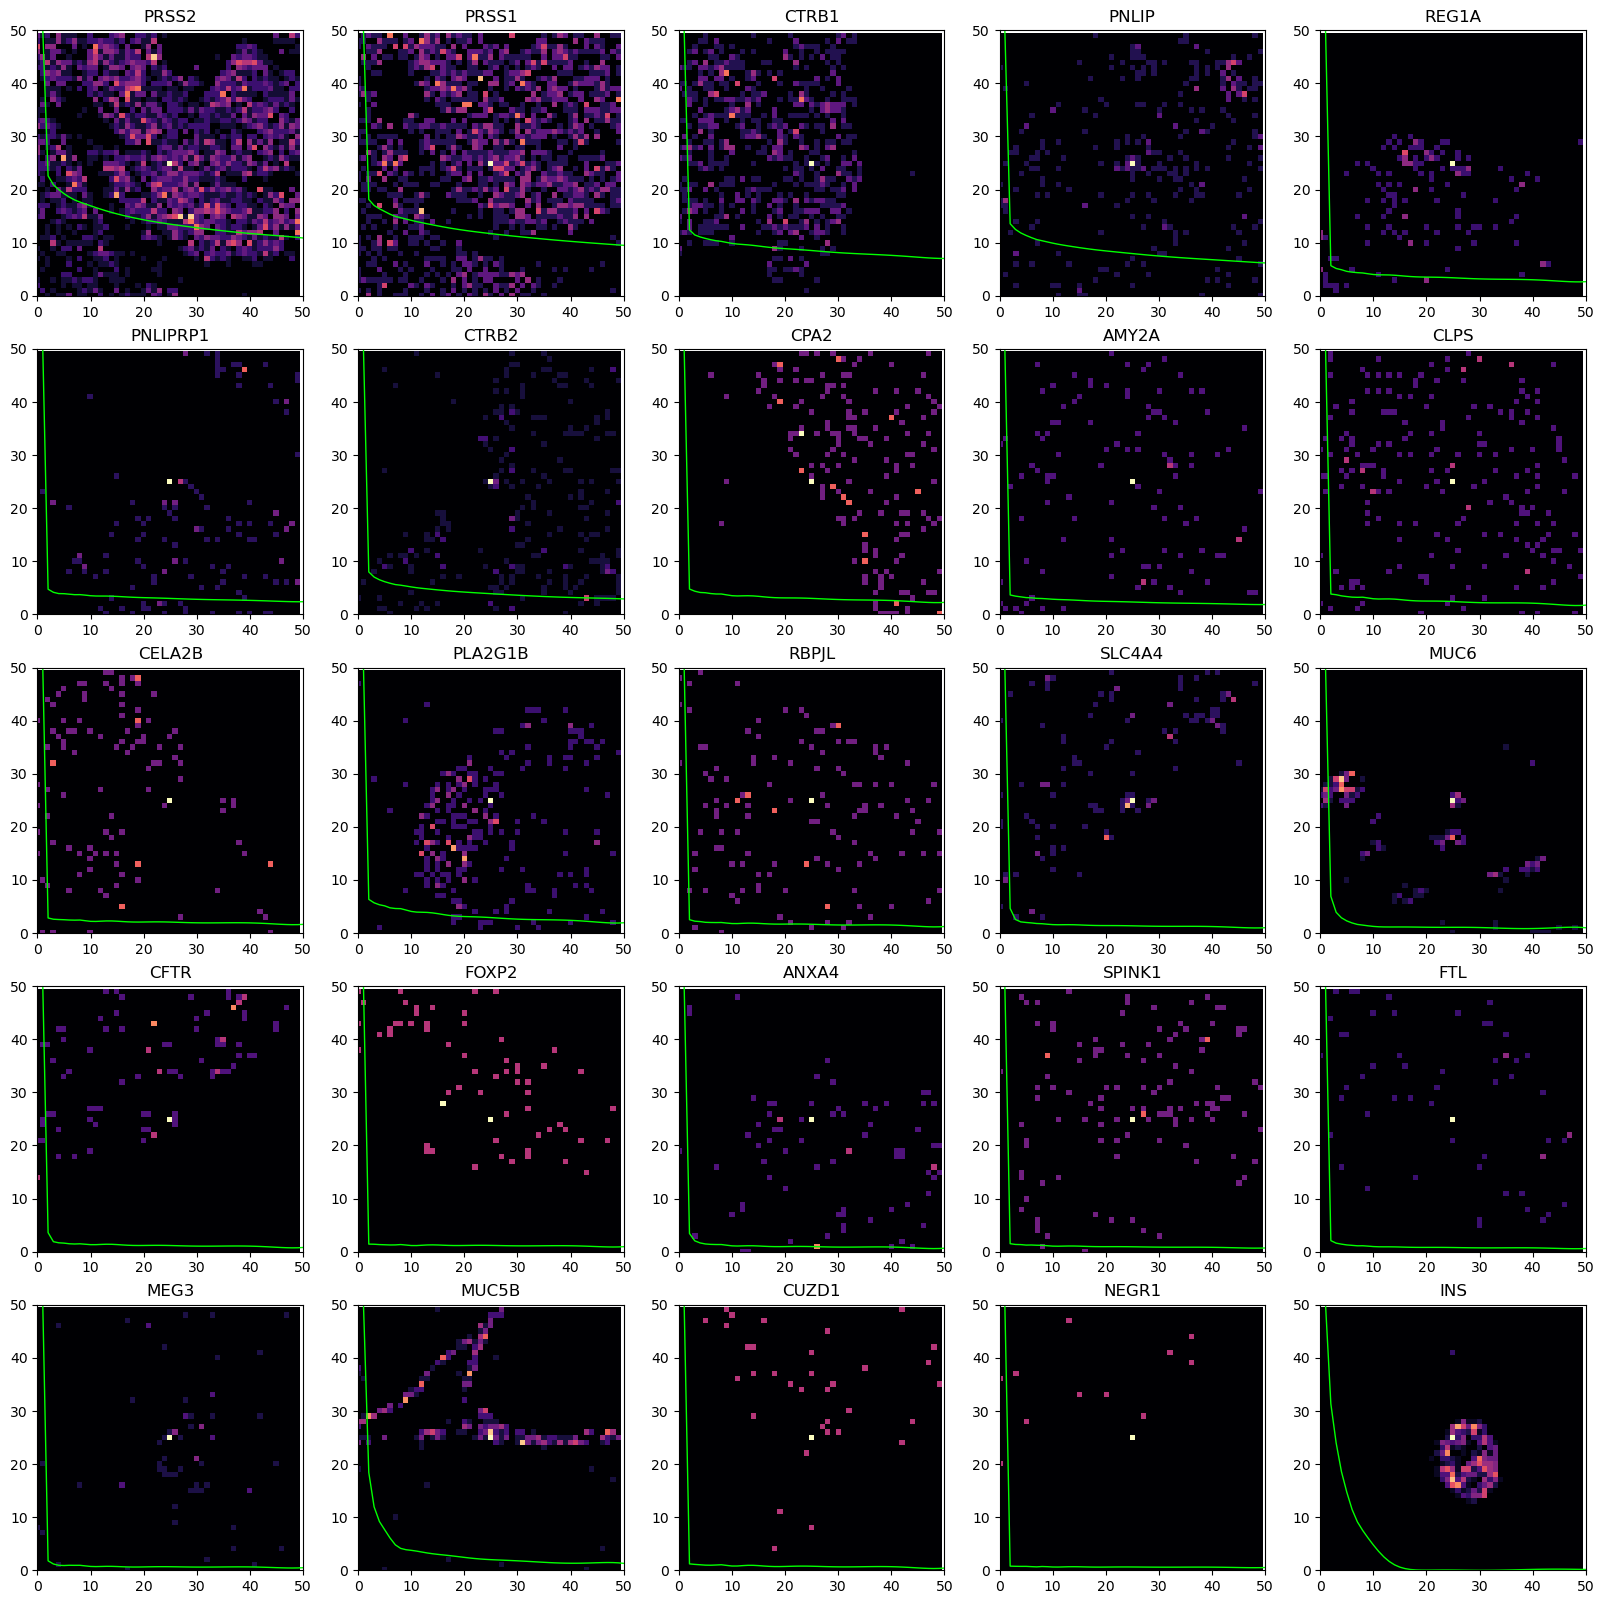

In [16]:
plt.figure(figsize=(20,20))

plot_len = cooc_template_.shape[2]//2

for im in range (25):

    plt.subplot(5,5, im+1) #background excluded

    sample_id = int(count_ids[-im-1])

    bg = point_process[sample_id].cpu().numpy()
    x_,y_ = [m[0] for m in np.where(bg[plot_len:-plot_len,plot_len:-plot_len]==bg[plot_len:-plot_len,plot_len:-plot_len].max())]

    bg = bg[x_:x_+plot_len*2,y_:y_+plot_len*2]
    plt.imshow(bg,cmap='magma')


    plotline = cooc_template_[sample_id,sample_id]
    plt.plot(np.linspace(1,bg.shape[1],plotline.shape[0]),plotline/plotline.max()*bg.shape[0],color='lime',linewidth=1)
    plt.title(gene_categories[sample_id])

    plt.gca().invert_yaxis()
    plt.xlim(0,bg.shape[1])
    plt.ylim(0,bg.shape[0])
    # break
